In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Постановка задач
нужно создать модель для классификации людей, растении и остальных классов

In [4]:
%cd /content/drive/MyDrive/сила света

/content/drive/MyDrive/сила света


In [5]:
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch
from torch.optim import lr_scheduler
import os
import cv2
import torch.nn.functional as F
import time
import copy

from sklearn.metrics import precision_score, recall_score , f1_score

In [6]:
%ls

data/      data.zip  ThePoweroflLight.ipynb  эксперименты.ipynb
data.json  models/   Untitled0.ipynb


## короткий анализ датасета

In [7]:
data = None
with open("data.json", 'r') as file:
  data = json.load(file)
data.keys()

dict_keys(['initial_bundle', 'test_bundle'])

разделение датасета на три заданных класса

In [8]:
def get_dataSet(origin_data, set_name = 'initial_bundle'):
  res_data = {'imgs':[], 'label':[]}
  for i in origin_data[set_name]:
    if i['category'] != None:
      if i['category']['name'] == 'Human':
        res_data['imgs'].append(i['file'])
        res_data['label'].append('Human')
      elif i['category']['name'] == 'Plants':
        res_data['imgs'].append(i['file'])
        res_data['label'].append('Plants')
      else:
        res_data['imgs'].append(i['file'])
        res_data['label'].append('Others')
  return pd.DataFrame(res_data)

In [9]:
train_set = get_dataSet(data, 'initial_bundle')
train_set.shape

(1558, 2)

In [10]:
test_set = get_dataSet(data, 'test_bundle')
test_set.shape

(1543, 2)

In [11]:
def show_pie(data_set, data_type):
  data_pie = [data_set[data_set['label'] == 'Plants'].count()['imgs'], data_set[data_set['label'] == 'Others'].count()['imgs'], data_set[data_set['label'] == 'Human'].count()['imgs'] ]
  lbls = ['Plants', 'Others', 'Human']
  plt.pie(data_pie, labels = lbls, autopct='%1.0f%%')
  plt.title(data_type)
  plt.show()

проверим сбалансированность классов

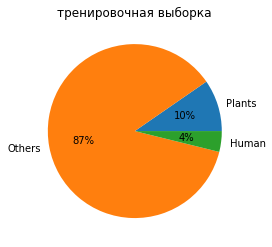

In [12]:
show_pie(train_set, 'тренировочная выборка')

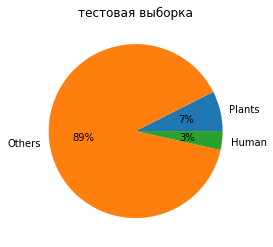

In [13]:
show_pie(test_set, 'тестовая выборка')

замечаем сильную несбалансированность

## поптыка решение несбалансированности с помощью аугментаци изображения

сперва посмотрим на некоторые данные из класса людей

In [14]:
images = []
for i in data['test_bundle']:
  if i['category'] != None:
    if i['category']['name'] == 'Human':
      images.append(i['file'])

data/21090cca-f1ee-4930-939c-976ab8a56c80.png
data/b1b7220c-7a94-4aca-aed4-25b0924b342f.png
data/a385a66b-6352-4264-b3d9-fe1da79514fc.png
data/a32ed1e2-b824-4ba6-b392-8436e3415ab9.png
data/afede752-275e-4a38-949e-79134cca72d2.png
data/6a3cc4c6-fce3-4524-aac5-45e550bf662c.png
data/da7dc5d4-3671-465d-bca9-f2ac8fee7028.png
data/f561792d-bfdf-40cc-a4ef-7f7f5e8cd605.png
data/21090cca-f1ee-4930-939c-976ab8a56c80.png
data/4663d1a4-098d-4b6b-8679-da17f45b775f.png
data/789494e1-6e90-4e86-85ca-9541aebf3628.png
data/521287d6-5b74-4fbf-b69f-03fc481b3404.png
data/ad46b36b-4a52-481c-a0d0-4aa98740b8c2.png
data/676976cd-6de5-4d5d-97c2-0cd157321a4c.png
data/676976cd-6de5-4d5d-97c2-0cd157321a4c.png
data/74e9bcc4-a459-4fbd-b111-945a02fc1b33.png


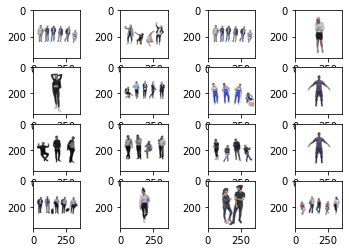

In [15]:
figure, axis = plt.subplots(4, 4)
x = 0
y = 0
for i in np.random.choice(images, 16):
  img = plt.imread(f'data/{i}')
  axis[x, y].imshow(img)
  print(i)
  x += 1
  if x > 3:
    x = 0
    y += 1

замечаем, что данные были созданы с определёнными правилами, так как фон абсолютно белый, то возникает идея воспользоваться алгоритмами кластеризации, чтобы определить пиксели принадлежащие к людям.

In [16]:
sample = plt.imread('data/data/c780a7d6-fabe-45d6-b786-46a9634dc0ee.png')

In [17]:
sample.shape

(360, 360, 4)

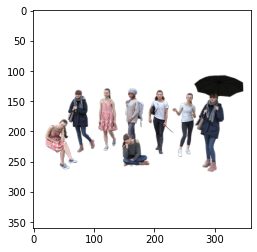

In [18]:
plt.imshow(sample)

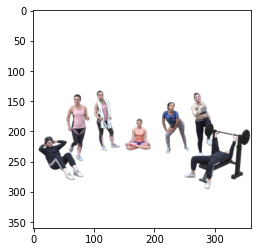

In [19]:
sample2 = plt.imread('data/data/6f749f24-d952-428c-8861-387d5d3778ef.png')
plt.imshow(sample2)

замечаем, что люди в изхображдениях не рандомные, а имеют общую черту, т.е. просто вырезать рандомных людей с одной картинки и вставить в дргую будет нарушать концепцию датасета, тогда можно в картинках с некоторыми людьми, удалить одну рандомную, и таким образом проводить аугментацию данных

In [20]:
humans = []
for i in range(sample2.shape[0]):
  for j in range(sample2.shape[1]):
    if sample[i, j, :].mean() > 0:
      humans.append([i, j, 0])
    else:
      humans.append([i, j, 1])

создаём новый дата сет, где в качестве признаков, будуб координаты пикселя, и принадлежность пикселя к фону либо к человеку, так как фон абсолютног белый, то любой не белый пиксель будет принадлежать людям 

In [21]:
humans = np.array(humans)

In [22]:
from sklearn.cluster import DBSCAN

In [23]:
clustering = DBSCAN(eps=0.5, min_samples=100).fit(humans)

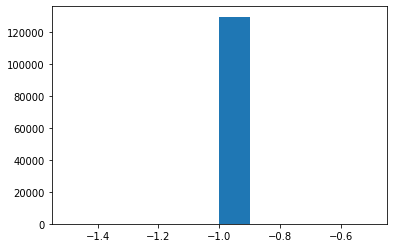

In [24]:
plt.hist(clustering.labels_)
plt.show()

проводим кластеризацию, но алгоритм смог найти только один класс вместо 6-ти людей. Сегментировать людей с помощью алгоритма кластеризации не удалось

In [25]:
clustering

DBSCAN(min_samples=100)

## Создание моедли на основе цветовых характеристик изображении

In [26]:
import cv2

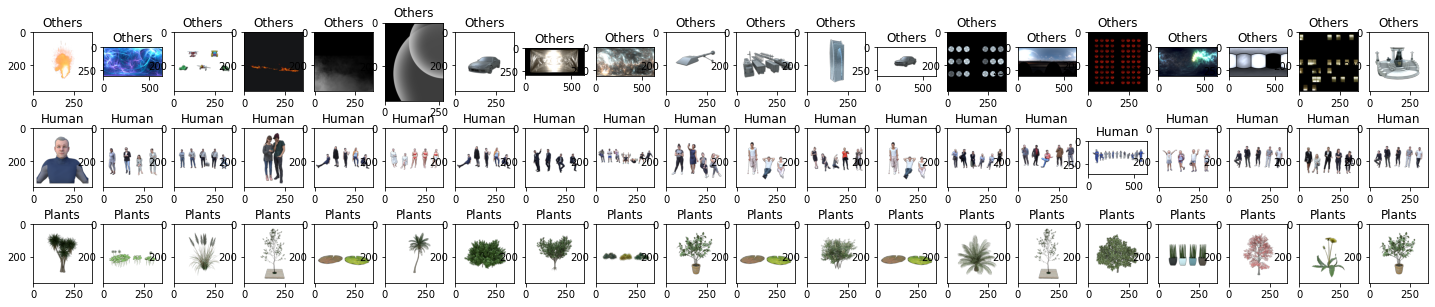

In [27]:
imgs_quent = 20

figure, axis = plt.subplots(3, imgs_quent,figsize=(25, 5))
x = 0
y = 0
for i in ['Others', 'Human', 'Plants']:
  for j in np.random.choice(train_set[train_set['label'] == i]['imgs'].values, imgs_quent):
    img = plt.imread(f'data/{j}')
    axis[y, x].imshow(img)
    axis[y, x].set_title(i)
    x += 1
    if x > imgs_quent - 1:
      x = 0
      y += 1
plt.show()

рассмотрим на нескольких представителей каждого класса, замечаем, что у каждого класса есть свой цветовой спектр. 

In [28]:
def get_color_feat(data):
  color_feat = []
  for i in data.values:
    img = cv2.imread(f'data/{i[0]}')
    r = np.histogram(img[:, :, 0])[0]
    g = np.histogram(img[:, :, 1])[0]
    b = np.histogram(img[:, :, 2])[0]
    color_feat.append(np.concatenate([r, g, b, [i[1]]]))
  return np.array(color_feat)

создаём функцию, из изображения создаёт вектор из цветовых гистограмм изображения.

In [29]:
train_clr = get_color_feat(train_set)
test_clr = get_color_feat(test_set)

так как проблему несбалансированности классов с помощью алгоритмов кластеризации не удалось, воспользуемся взвешенной функцией потерь

In [30]:
print('Others' ,train_set[train_set["label"] == 'Others']["label"].shape[0])
print('Plants', train_set[train_set['label'] == 'Plants']['label'].shape[0])
print('Human',train_set[train_set['label'] == 'Human']['label'].shape[0])

Others 1348
Plants 150
Human 60


In [31]:
others = 2
plants = 4
human = 9

In [32]:
from sklearn.linear_model import LogisticRegression

определяем модель с весами каждого класса, обучаем.

In [33]:
clf = LogisticRegression(class_weight={'Others':others, 'Plants':plants, 'Human':human}).fit(train_clr[:, :-1],train_clr[:, -1] )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [34]:
predicts = clf.predict(test_clr[:, :-1])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


рассмотрим распределение предсказании

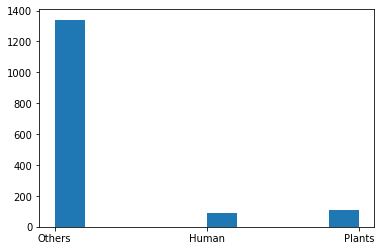

In [35]:
plt.hist(predicts)
plt.show()

метрики

In [36]:
f1_score(test_clr[:, -1], predicts, average='macro')

0.5397106495726208

In [37]:
precision_score(test_clr[:, -1], predicts, average='macro')

0.54055862780695

In [38]:
recall_score(test_clr[:, -1], predicts, average='macro')

0.5435621749209497

показатели достаточно низкие, воспользуемся более сильной моделью, аналогично с взвешенной функцией потерь

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rand_forest = RandomForestClassifier(max_depth=3, class_weight={'Others':others, 'Plants':plants, 'Human':human}).fit(train_clr[:, :-1],train_clr[:, -1] )

In [41]:
predicts = clf.predict(test_clr[:, :-1])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


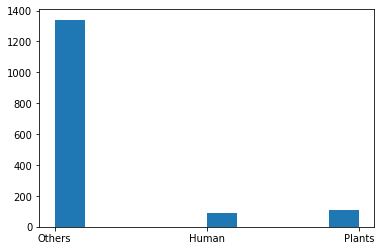

In [42]:
plt.hist(predicts)
plt.show()

In [43]:
f1_score(test_clr[:, -1], predicts, average='macro')

0.5397106495726208

In [44]:
precision_score(test_clr[:, -1], predicts, average='macro')

0.54055862780695

In [45]:
recall_score(test_clr[:, -1], predicts, average='macro')

0.5435621749209497

## Нейросети

воспользуемся архитектурой resNet18 c предобученными весами, и с взвешанной кросс эентропией для решения проблем несбалансированности классов

In [46]:
batch_size = 32

создаём dataLoader

In [47]:
class Data(Dataset):
  def __init__(self, data_csv, phase = 'train'):
    self.images = data_csv['imgs'].values
    self.label = data_csv['label'].values
    self.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((225, 225)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    self.encoder = {
        'Others':0,
        'Plants':1,
        'Human':2
    }
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_full_name = f'data/{self.images[idx]}'
    img = cv2.imread(image_full_name)
    img = self.transform(img)
    return img,self.encoder[self.label[idx]]

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [49]:
train_data = Data(train_set, 'train')
test_data =  Data(test_set, 'test')

In [50]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

In [51]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':train_set.shape[0],
    'val':test_set.shape[0]
}

In [52]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0
    best_recall = 0.0
    best_precision = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0.0
            running_precision = 0.0
            running_recall = 0.0

            losses = []
            f1_scores = []
            precisions = []
            recalls = []


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                
                losses.append(loss.to(cpu).detach().numpy())
                f1_scores.append(f1_score(labels.to(cpu).detach().numpy(), preds.to(cpu).detach().numpy(), average='macro'))
                recalls.append(recall_score(labels.to(cpu).detach().numpy(), preds.to(cpu).detach().numpy(), average='macro'))
                precisions.append(precision_score(labels.to(cpu).detach().numpy(), preds.to(cpu).detach().numpy(), average='macro'))

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            running_f1 = np.mean(f1_scores)
            running_precision = np.mean(precisions)
            running_recall = np.mean(recalls)

            plt.plot(losses)
            plt.grid(True)
            plt.show()

            print('{} Loss: {:.4f} Acc: {:.4f} f1: {:.4f} precision {:.4f} recall {:.4f}'.format(
                phase, epoch_loss, epoch_acc, running_f1 , running_precision, running_recall))

            # deep copy the model
            if phase == 'val' and ( running_f1 + running_recall + running_precision )  > (best_f1 + best_recall + best_precision):
                best_f1 = running_f1
                best_recall = running_recall
                best_precision = running_precision
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [53]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [54]:
weights = torch.Tensor([10,5, 1 ]).to(device)

In [55]:
criterion = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model_ft.parameters(), lr=0.0005)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

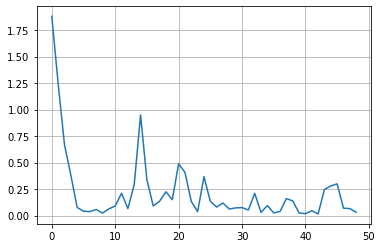

train Loss: 0.2226 Acc: 0.8870 f1: 0.6349 precision 0.6582 recall 0.6435


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Re

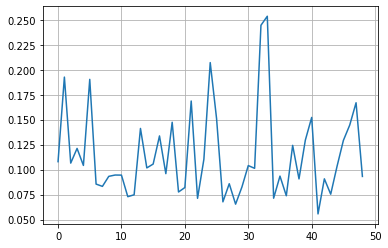

val Loss: 0.1149 Acc: 0.9436 f1: 0.6524 precision 0.6476 recall 0.6750

Epoch 1/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

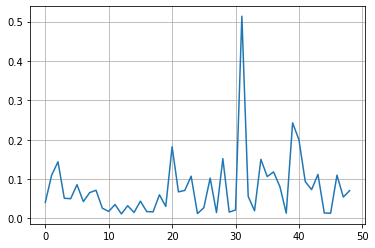

train Loss: 0.0772 Acc: 0.9442 f1: 0.7854 precision 0.8452 recall 0.7591


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

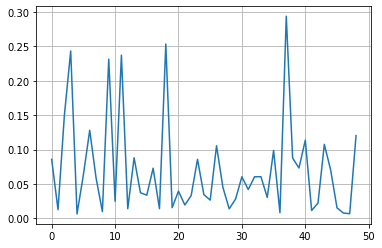

val Loss: 0.0706 Acc: 0.9637 f1: 0.8381 precision 0.8439 recall 0.8543

Epoch 2/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

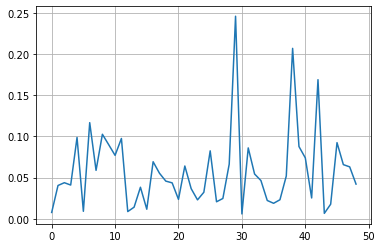

train Loss: 0.0582 Acc: 0.9583 f1: 0.8518 precision 0.8969 recall 0.8445


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

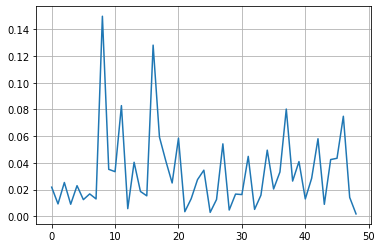

val Loss: 0.0334 Acc: 0.9799 f1: 0.9157 precision 0.9458 recall 0.9043

Epoch 3/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

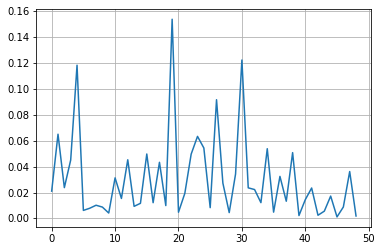

train Loss: 0.0308 Acc: 0.9788 f1: 0.9254 precision 0.9507 recall 0.9200


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defi

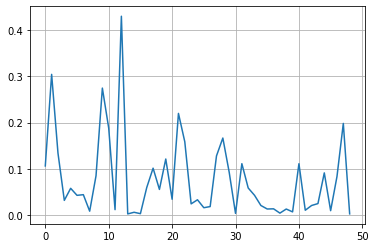

val Loss: 0.0786 Acc: 0.9682 f1: 0.8729 precision 0.8732 recall 0.8925

Epoch 4/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defi

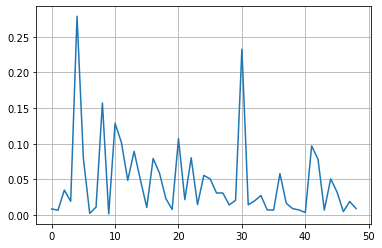

train Loss: 0.0478 Acc: 0.9641 f1: 0.8363 precision 0.8638 recall 0.8278


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

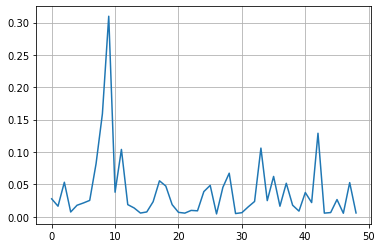

val Loss: 0.0396 Acc: 0.9695 f1: 0.8862 precision 0.9202 recall 0.8743

Epoch 5/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Re

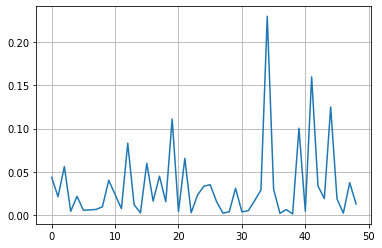

train Loss: 0.0340 Acc: 0.9724 f1: 0.9031 precision 0.9408 recall 0.8973


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

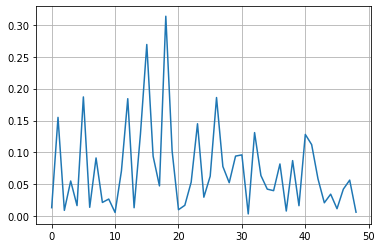

val Loss: 0.0744 Acc: 0.9592 f1: 0.8351 precision 0.8314 recall 0.8716

Epoch 6/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

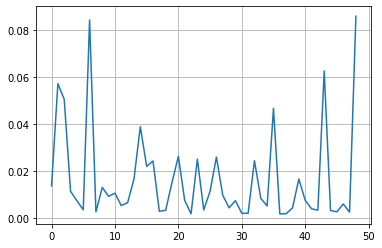

train Loss: 0.0161 Acc: 0.9827 f1: 0.9279 precision 0.9451 recall 0.9248


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

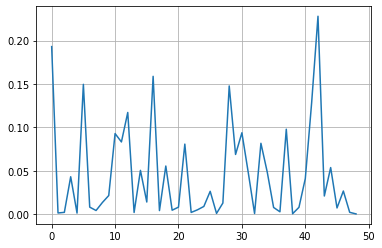

val Loss: 0.0472 Acc: 0.9695 f1: 0.8506 precision 0.8928 recall 0.8309

Epoch 7/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is 

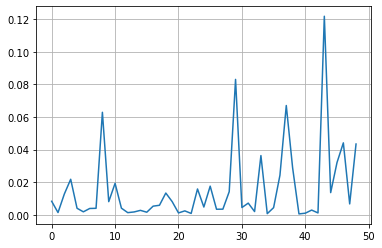

train Loss: 0.0158 Acc: 0.9840 f1: 0.9185 precision 0.9277 recall 0.9157


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

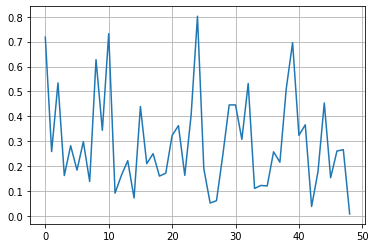

val Loss: 0.3003 Acc: 0.8833 f1: 0.5960 precision 0.5608 recall 0.7131

Epoch 8/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

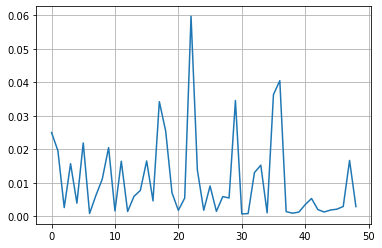

train Loss: 0.0110 Acc: 0.9859 f1: 0.9375 precision 0.9573 recall 0.9328


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


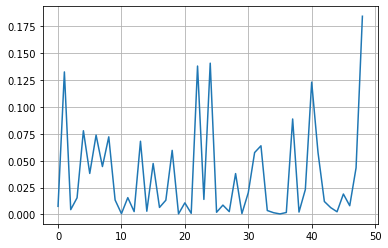

val Loss: 0.0338 Acc: 0.9838 f1: 0.9427 precision 0.9535 recall 0.9460

Epoch 9/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


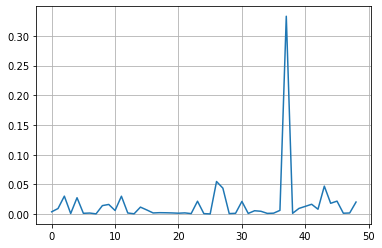

train Loss: 0.0170 Acc: 0.9872 f1: 0.9581 precision 0.9736 recall 0.9545


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

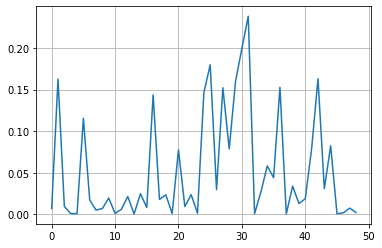

val Loss: 0.0540 Acc: 0.9644 f1: 0.8158 precision 0.8506 recall 0.8021

Epoch 10/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-d

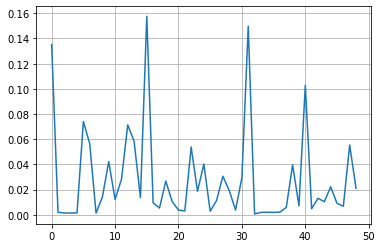

train Loss: 0.0286 Acc: 0.9807 f1: 0.9135 precision 0.9380 recall 0.9064


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

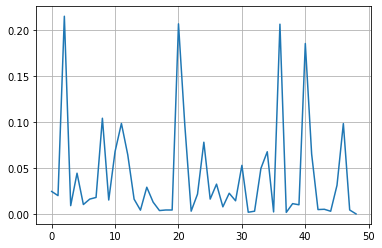

val Loss: 0.0434 Acc: 0.9650 f1: 0.8409 precision 0.8746 recall 0.8305

Epoch 11/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

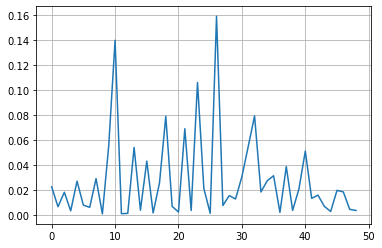

train Loss: 0.0282 Acc: 0.9730 f1: 0.9008 precision 0.9297 recall 0.8955


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

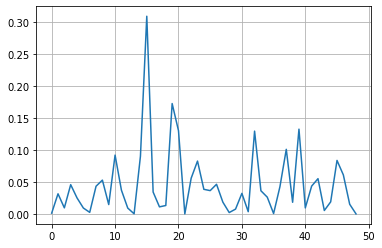

val Loss: 0.0470 Acc: 0.9760 f1: 0.8988 precision 0.9083 recall 0.9081

Epoch 12/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


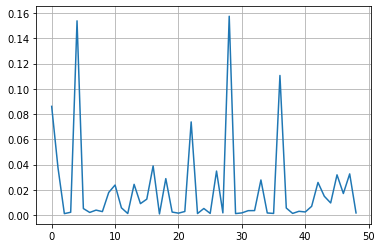

train Loss: 0.0215 Acc: 0.9897 f1: 0.9752 precision 0.9848 recall 0.9707


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-d

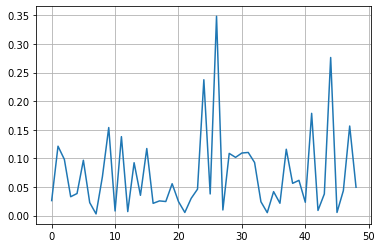

val Loss: 0.0730 Acc: 0.9702 f1: 0.8832 precision 0.8755 recall 0.9183

Epoch 13/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


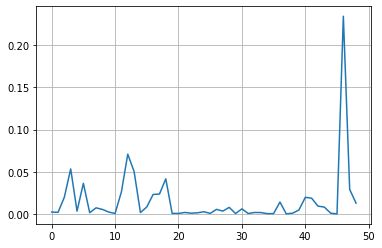

train Loss: 0.0160 Acc: 0.9904 f1: 0.9594 precision 0.9697 recall 0.9550


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

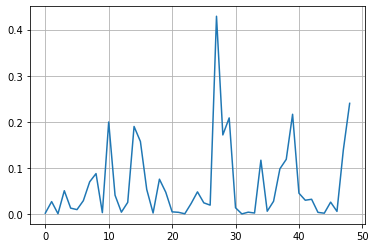

val Loss: 0.0616 Acc: 0.9611 f1: 0.8206 precision 0.8832 recall 0.8021

Epoch 14/14
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


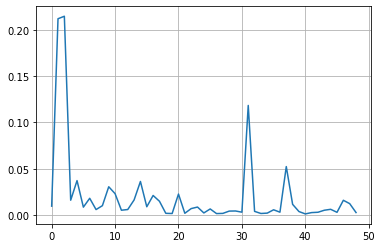

train Loss: 0.0208 Acc: 0.9859 f1: 0.9541 precision 0.9764 recall 0.9483


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

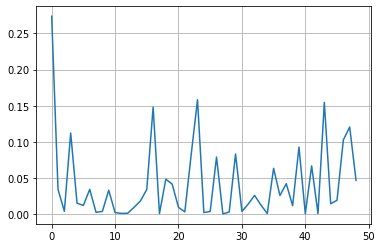

val Loss: 0.0426 Acc: 0.9754 f1: 0.8645 precision 0.9055 recall 0.8464

Training complete in 7m 46s
Best val Acc: 0.000000


In [56]:
best_model = train_model(model_ft, criterion, optimizer, num_epochs=15)

получили достаточно хороший результат, не прибегая к аугментации данных, были идели воспользоваться моделями Yolo и DeepLab3 для того, чтобы сперва задетектить людей, а потом засегментированный участок отбелить, таки мобразом создавая новые образцы данных, но результат был достигнут и без применения относительно тяжёлых моделей

In [57]:
torch.save(best_model.state_dict(), './models/model2')

сохраняем модель

In [66]:
mymodel = models.resnet18()
num_ftrs = mymodel.fc.in_features
mymodel.fc = nn.Linear(num_ftrs, 3)

In [72]:
mymodel.load_state_dict(torch.load('./models/model2'))
mymodel.eval()
mymodel.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
def eval(model):
  losses = []
  f1_scores = []
  precisions = []
  recalls = []
  running_corrects = 0

  # Iterate over data.
  for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # track history if only in train
      model.eval()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      f1_scores.append(f1_score(labels.to(cpu).detach().numpy(), preds.to(cpu).detach().numpy(), average='macro'))
      recalls.append(recall_score(labels.to(cpu).detach().numpy(), preds.to(cpu).detach().numpy(), average='macro'))
      precisions.append(precision_score(labels.to(cpu).detach().numpy(), preds.to(cpu).detach().numpy(), average='macro'))

      running_corrects += torch.sum(preds == labels.data)


  running_f1 = np.mean(f1_scores)
  running_precision = np.mean(precisions)
  running_recall = np.mean(recalls)

  epoch_acc = running_corrects.double() / dataset_sizes['val']



  print('acc {:.4f} f1: {:.4f} precision {:.4f} recall {:.4f}'.format(
      epoch_acc, running_f1 , running_precision, running_recall))


проверка сохранённой модели

In [75]:
eval(mymodel)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc 0.9838 f1: 0.9499 precision 0.9634 recall 0.9508


In [77]:
!pip3 freeze > requirements.txt 